# Predict the rating of books or beers

## Books rating prediction (regression)

Using the book review data, let’s see whether ratings can be predicted as a function of review length, or by using temporal features associated with a review.

Dataset:
GoodReads Fantacy Reviews: https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/fantasy_10000.json.gz

Executing the code requires a working install of Python 2.7 or Python 3 with the scipy packages installed.

In [1]:
# import some library
import gzip # for opening the .gz file
import json # for opening the .json file
import sklearn # for linear model
from sklearn import linear_model
import numpy # for plotting the fitting line
import matplotlib.pyplot as plt # for plotting the fitting line

In [2]:
# Get the data
!wget 'https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/fantasy_10000.json.gz'
f = gzip.open("fantasy_10000.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

f.close()

--2023-11-25 19:09:12--  https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/fantasy_10000.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3798634 (3.6M) [application/x-gzip]
Saving to: ‘fantasy_10000.json.gz’

fantasy_10000.json. 100%[===================>]   3.62M  --.-KB/s    in 0.1s    

2023-11-25 19:09:12 (33.1 MB/s) - ‘fantasy_10000.json.gz’ saved [3798634/3798634]



In [3]:
# Let's see what the data looks like
dataset[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '18245960',
 'review_id': 'dfdbb7b0eb5a7e4c26d59a937e2e5feb',
 'rating': 5,
 'review_text': 'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would 

### 1. Train a simple predictor that estimate rating from review length

> star rating ≃ θ𝟢 + θ𝟣*[review length in characters]

The model will calculate θ𝟢 and θ𝟣 based on the features and label we give.

Rather than using the review length directly, we'll scale the feature to be between 0 and 1 by dividing by the maximum review length in the dataset.

In [4]:
# Get maximun review length from training data
maxLen = max([len(d['review_text']) for d in dataset])
maxLen

14306

In [5]:
# function for creating the feature
def feature(datum):
  feat = []
  feat.append(1) # offest term
  feat.append(len(datum['review_text']) / maxLen) # append the normalized length of review
  return feat

In [6]:
# Create features X and labels y
X = [feature(d) for d in dataset]
y = [d['rating'] for d in dataset]

In [7]:
X[:5], y[:5]

([[1, 0.14581294561722355],
  [1, 0.10631902698168601],
  [1, 0.1061792254997903],
  [1, 0.1251922270376066],
  [1, 0.12316510555011884]],
 [5, 5, 5, 4, 3])

sklearn linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [8]:
# Fit a linear regression model to the data (sklearn)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [9]:
# Extract the model coefficients (theta)
theta = model.coef_
theta # theta0, theta1

array([3.68568136, 0.98335392])

θ𝟢 = 3.685 means if the review length is 0, the predicted rating is 3.685

θ𝟣 = 0.983 means if the normalized review length go up by 1, the predicted rating go up by 0.983

In [10]:
# we can plot the fitting line
xplot = numpy.arange(0,1,0.01)
yplot = [(theta[0] + theta[1]*x).item() for x in xplot]

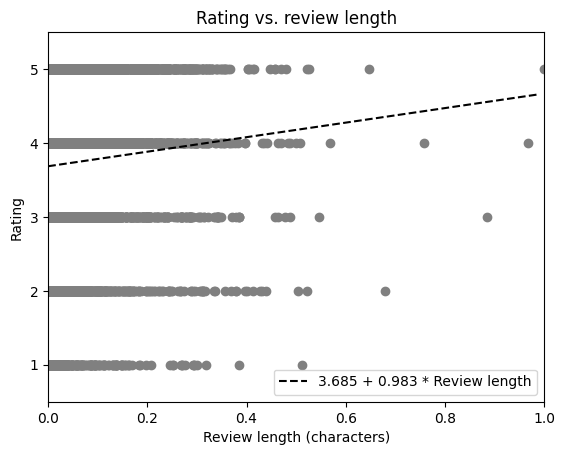

In [11]:
ratings = [d['rating'] for d in dataset]
lengths = [len(d['review_text']) for d in dataset]

plt.scatter([l / maxLen for l in lengths], ratings, color='grey')
plt.plot(numpy.array(xplot), yplot, color = 'k', linestyle = '--',\
         label = r"3.685 + 0.983 * Review length")
plt.xlim(0, 1)
plt.ylim(0.5, 5.5)
plt.xlabel("Review length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. review length")
plt.legend(loc='lower right')
plt.show()

We can see that it is hard to predict rating just using a single line because we use only one feature (review length).

One way the improve is to **use more features**.

### 2. Extend your model to include (in addition to the scaled length) features based on the time of the review.

You can pares the time data as follows:

In [34]:
import dateutil.parser
for d in dataset:
    t = dateutil.parser.parse(d['date_added'])
    d['parsed_date'] = t # add parsed date info to dataset

In [35]:
dataset[0]['parsed_date']

datetime.datetime(2017, 7, 30, 7, 44, 10, tzinfo=tzoffset(None, -25200))

Using a one-hot encoding for the weekday and month. Be careful not to include any redundant dimensions: e.g. your feature vector, including the offset term and the length feature, should contain no more than 19 dimensions.

e.g. We present the first weekday as all zeros, We only need 6 spots for 7 days

Monday = [0, 0, 0, 0, 0, 0]

Tuesday = [1, 0, 0, 0, 0, 0]

Wednesday = [0, 1, 0, 0, 0, 0]

Thursday = [0, 0, 1, 0, 0, 0]

Friday = [0, 0, 0, 1, 0, 0]

Saturday = [0, 0, 0, 0, 1, 0]

Sunday = [0, 0, 0, 0, 0, 1]

In [36]:
def feature_onehot(datum):
    f = [1, len(datum['review_text']) / maxLen] # offset term and normalized review length
    pd = datum['parsed_date']
    wday = [0] * 7 # one-hot encoding for weekdays
    wday[pd.weekday()] = 1
    mon = [0] * 12 # one-hot encoding for months
    mon[pd.month - 1] = 1
    return f + wday[1:] + mon[1:]

In [45]:
# Create features X and labels y
X_onehot = [feature_onehot(d) for d in dataset]
y_onehot = [d['rating'] for d in dataset]

In [46]:
X_onehot[0], y_onehot[0]

([1, 0.14581294561722355, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 5)

### 3. Train 2 models

1.   use the weekday and month values directly as features, i.e.,
> star rating ≃ θ𝟢 + θ𝟣 × [review length in characters] + θ𝟤 × [t.weekday()] + θ𝟥 × [t.month]

2.   use the one-hot encoding from Question 2.
> star rating ≃ θ𝟢 + θ𝟣 × [review length in characters] + θ𝟤 × [weekdays one-hot] + θ𝟥 × [months one-hot]


1.   use the weekday and month values directly as features

In [40]:
def feature3(datum):
    pd = datum['parsed_date']
    f = [1, len(datum['review_text']) / maxLen, pd.weekday(), pd.month] # offset term, review length, weekday, month
    return f

In [41]:
X3 = [feature3(d) for d in dataset]
y3 = [d['rating'] for d in dataset]

In [51]:
# Fit a linear regression model to the data (sklearn)
model3 = linear_model.LinearRegression(fit_intercept=False)
model3.fit(X3, y3)

LinearRegression(fit_intercept=False)

In [53]:
# Extract the model coefficients (theta)
theta3 = model3.coef_
theta3 # There are 4 thetas, included (theta0, review length, weekdays, months)

array([ 3.68774185,  0.98716703,  0.00968863, -0.00457118])

2.   use the one-hot encoding from Question 2.

In [67]:
# Fit a linear regression model to the data (sklearn)
model_onehot = linear_model.LinearRegression(fit_intercept=False)
model_onehot.fit(X_onehot, y_onehot)

LinearRegression(fit_intercept=False)

In [68]:
# Extract the model coefficients (theta)
theta_onehot = model_onehot.coef_
theta_onehot # There are 19 thetas, included (theta0, review length, 6 thetas for weekdays, 11 thetas for months)

array([ 3.75140188e+00, -7.03522435e-02, -3.80551209e-02,  3.73721892e-03,
        6.93141433e-02, -1.50087754e-02, -9.96762687e-02,  2.31782857e-02,
       -1.23345819e-01, -2.41107291e-02,  2.95825559e-02,  9.44765224e-03,
       -3.03154970e-02,  8.83894467e-02,  7.44512440e-04,  1.06874106e-02,
       -2.48957575e-02,  3.75625754e-02, -2.44154390e-03])

### 4. Split the data into a training and test set.

Lst's Split the data into 50%/50% train/test fractions.

After training on the training set, report the MSE of the two models.

In [62]:
# We can use random seed
import random
random.seed(0)
random.shuffle(dataset)

In [63]:
X_onehot = [feature_onehot(d) for d in dataset]
X3 = [feature3(d) for d in dataset]
y = [d['rating'] for d in dataset]

In [64]:
train_onehot, test_onehot = X_onehot[:len(X_onehot)//2], X_onehot[len(X_onehot)//2:]
train3, test3 = X3[:len(X3)//2], X3[len(X3)//2:]
trainY, testY = y[:len(y)//2], y[len(y)//2:]

In [65]:
model_onehot = linear_model.LinearRegression()
model_onehot.fit(train_onehot,trainY)
pred_onehot = model_onehot.predict(test_onehot)
test_mse_onehot = sum([(yp - yt)**2 for (yp,yt) in zip(pred_onehot, testY)]) / len(testY)

model3.fit(train3,trainY)
pred3 = model3.predict(test3)
test_mse3 = sum([(yp - yt)**2 for (yp,yt) in zip(pred3, testY)]) / len(testY)

In [66]:
test_mse_onehot, test_mse3

(1.6264453676167878, 1.628291947617607)

## Beers rating prediction (classification)

Using the beer review data, we’ll try to predict ratings (positive or negative) based on characteristics of beer reviews. Load the 50,000 beer review dataset, and construct a label vector by considering
whether a review score is four or above, i.e.,
> y = [ d[ ’review/overall’ ] >= 4 for d in dataset ]

Dataset:
Beer Reviews: https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/beer_50000.json

In [70]:
# Get the data
!wget 'https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/beer_50000.json'
f = open("beer_50000.json")
dataset = []
for l in f:
    dataset.append(eval(l))

--2023-11-25 20:52:39--  https://cseweb.ucsd.edu/classes/fa23/cse258-a/data/beer_50000.json
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61156124 (58M) [application/json]
Saving to: ‘beer_50000.json.1’

beer_50000.json.1   100%[===================>]  58.32M   172MB/s    in 0.3s    

2023-11-25 20:52:40 (172 MB/s) - ‘beer_50000.json.1’ saved [61156124/61156124]



In [71]:
# What the data looks like
dataset[0]

{'review/appearance': 2.5,
 'beer/style': 'Hefeweizen',
 'review/palate': 1.5,
 'review/taste': 1.5,
 'beer/name': 'Sausa Weizen',
 'review/timeUnix': 1234817823,
 'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'review/timeStruct': {'isdst': 0,
  'mday': 16,
  'hour': 20,
  'min': 57,
  'sec': 3,
  'mon': 2,
  'year': 2009,
  'yday': 47,
  'wday': 0},
 'review/overall': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'user/profileName': 'stcules',
 'review/aroma': 2.0}

### 1. Fit a logistic regressor that estimates the binarized score from review length

> p (rating is positive) ≃ σ( θ𝟢 + θ𝟣 × [length] )

Using the class weight=’balanced’.

We'll calculate the numbers of True Positives, True Negatives, False
Positives, False Negatives, and the Balanced Error Rate of the classifier.

In [72]:
# Predict the user's review from the length of their review
# Create the features X and labels y
X = [[1, len(d['review/text'])] for d in dataset] # offset term and review length
y = [d['review/overall'] >= 4 for d in dataset] # True if rating >=4

sklearn logistic regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [74]:
# Fit a logistic regression model to the data (sklearn)
model = linear_model.LogisticRegression(class_weight='balanced')
model.fit(X, y)

LogisticRegression(class_weight='balanced')

In [76]:
# Make predictions
predictions = model.predict(X) # Binary vector of predictions
predictions

array([False, False, False, ..., False,  True, False])

In [80]:
# True Positives, True Negatives, False Positives, False Negatives
TP = sum([(p and l) for (p,l) in zip(predictions, y)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y)])

In [81]:
# True positive and true negative rates
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
TPR, TNR

(0.4224979174104487, 0.6408957773980962)

In [82]:
# BER
BER = 1 - 1/2 * (TPR + TNR)
BER

0.4683031525957275

### 2. Compute the precision@K of the classifier for K ∈ {1, 100, 1000, 10000}

To calculate precision@K, we need to first sort the predict results based on the confidiences (scores)

In [84]:
# get the confidiences (scores)
confidences = model.decision_function(X) # real vector of confidences
confidences

array([-0.15815583, -0.13125069, -0.11071781, ..., -0.02398413,
        0.09673501, -0.09195502])

In [86]:
# sort the confiences and zip it with label y
sortedByConfidence = list(zip(confidences ,y))
sortedByConfidence.sort(reverse=True)
sortedByConfidence[:10]

[(1.42039730878528, True),
 (1.4087148118877324, True),
 (1.3478242219974843, True),
 (1.3127767313048417, True),
 (1.2858715869347321, True),
 (1.2582584124496197, True),
 (1.22391895187198, False),
 (1.1994919129043804, True),
 (1.1803750997993026, True),
 (1.174356843821778, False)]

In [88]:
# Compput the precision@K
precs = []
for k in [1,100,1000,10000]:
    precision_at_k = sum([sortedByConfidence[i][1] for i in range(k)]) / k
    precs.append(precision_at_k)
    print("Precision@" + str(k) + " = " + str(precision_at_k))
precs

Precision@1 = 1.0
Precision@100 = 0.75
Precision@1000 = 0.71
Precision@10000 = 0.7147


[1.0, 0.75, 0.71, 0.7147]

### 3. Improve the predictor

specifically, reduce the balanced error rate by incorporating additional features from the data (e.g. beer styles, ratings, features from text, etc.)

In [89]:
# Predict the user's review by incorporating review length, beer/ABV and beer/brewerId from the data
def feature(d):
    feat = [1] # offset term
    feat.append(len(d['review/text']))
    feat.append(d['beer/ABV'])
    feat.append(int(d['beer/brewerId']))
    return feat

In [90]:
X = [feature(d) for d in dataset]
y = [d['review/overall'] >= 4 for d in dataset]

In [91]:
X[0], y[0]

([1, 262, 5.0, 10325], False)

In [95]:
# Using the class weight=’balanced’ option
model = linear_model.LogisticRegression(class_weight='balanced')
model.fit(X, y)

LogisticRegression(class_weight='balanced')

In [96]:
predictions = model.predict(X)
predictions

array([False, False, False, ...,  True,  True,  True])

In [97]:
# True positives, False positives (etc.), and balanced error rate (BER)
TP = sum([(p and l) for (p,l) in zip(predictions, y)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y)])

# True positive and true negative rates
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

BER = 1 - 1/2 * (TPR + TNR)
BER

0.40920242506112414

The BER reduce after using more features